In [1]:
library(readxl)
library(glue)
library(ggplot2)
library(lmtest)
library(car)
library(tsoutliers)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: carData

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
# Loading the data
data <- read_excel('Demanda de electricidad.xlsx', range='B3:P195')

# Removing unnecessary columns
data <- subset(data, select=c('Mes', 'Demanda Distribuidoras [GWh]', 
                              'Precio Monómico Medio Total Ajustado', 
                              'Precio Estacional Medio Total Ajustado',
                              'Temperatura Máxima Media CABA',
                              'Temperatura Mínima Media CABA',
                              'EMAE', 'Índice de Salarios Ajustado'))

# Removing rows with missing data
data <- data[data['Mes'] > '2010-12-01', ]

# Renaming columns to make the following code less verbose
colnames(data) <- c('date', 'demand', 'pmon', 'pest', 'tempmax', 'tempmin', 
                    'emae', 'wages')

# Multiplying the demand column by 1000 to keep units consistent
data$demand <- data$demand * 1000


# Showing some info about the data
sprintf("This table has %s rows", nrow(data))
sprintf("This table has %s columns", ncol(data))
head(data)
tail(data)

[1] "This table has 144 rows"

[1] "This table has 8 columns"

date,demand,pmon,pest,tempmax,tempmin,emae,wages
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-01-01,8328000,105.0760,25.60751,30.6,20.9,133.0769,9.942560
2011-02-01,7137000,104.4436,27.37540,28.6,19.4,129.5099,9.948214
2011-03-01,7676000,109.6044,25.49944,27.4,17.6,147.0018,9.829062
2011-04-01,6892000,111.8010,24.68552,23.7,14.1,151.0358,9.756036
2011-05-01,7500000,177.7511,23.26954,19.0,10.7,166.1783,9.871641
2011-06-01,8153000,204.3614,20.96642,15.6,8.4,156.6937,10.088253


date,demand,pmon,pest,tempmax,tempmin,emae,wages
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-07-01,10698000,184.77034,52.88387,16.4,8.8,151.2415,7.662978
2022-08-01,9825000,145.71764,50.53381,18.5,9.0,150.2282,7.630726
2022-09-01,8354000,121.48339,56.05449,20.9,10.8,148.1328,7.671190
2022-10-01,8247000,77.62828,55.44866,23.3,13.0,146.2924,7.584137
2022-11-01,9286000,98.43075,55.34205,28.3,17.7,147.7913,7.713741
2022-12-01,11034000,116.08620,50.95990,30.5,19.7,145.7290,7.724100


In [3]:
# Defining a few useful functions

scatter_plot <- function(y, x) {
    ggplot(data, aes_string(x=x, y=y)) +
           geom_point() 
}

build_formula <- function(predicted, predictors) {
    form_str <- glue(predicted, ' ~ ')
    for (i in predictors) {
        var_str <- glue(i, ' + ')
        form_str <- glue(form_str, var_str)
    }
    form_str <- substr(form_str, 1, nchar(form_str)-3)
    return(form_str)
}

build_model <- function(form_str, data, show=TRUE) {
    model <- lm(form_str, data)
    if (show){
        print(summary(model))
    }
    return(model)
}

autocorr_test <- function(model, data) {
    print(durbinWatsonTest(model))
    data$resid <- model$residuals
    ggplot(data, aes_string(x='date', y='resid')) +
           geom_point() }

reset_test <- function(model) { 
    resettest(model, power = 2, type = "fitted", data = data)
}

heterosk_check <- function(model) {
    p <- bptest(model)$p.value
    print(sprintf('The p-value of the Breusch-Pagan test is %s', p))
    ggplot(model, aes(x = .fitted, y = .resid)) +
    geom_point() +
    geom_hline(yintercept = 0, colour='red')
}

hyp_test <- function(model, predictors) {
    new_vector <- paste(predictors, '=0', sep = '')
    linearHypothesis(model, new_vector)
} 

res_dist <- function(model) {
    ggplot(model, aes(x=.resid)) + 
    geom_histogram(aes(y=after_stat(density)), colour="black", fill="white") +
    geom_density(alpha=.2, fill="#FF6666")    
}

pred_intervals <- function(model, predictors, data){
    predictors_df <- data[, predictors]
    preds <- data.frame(predict(model, data=predictors_df, interval='predict'))
    preds$true <- data$demand
    
    # Counting the values outside the prediction interval
    n_outside <- nrow(preds[(preds$lwr > preds$true) | (preds$upr < preds$true), ])
    print(sprintf("There are %s true values outside the prediction interval, with n=144", n_outside))

    # Plotting the prediction interval
    ggplot(preds, aes(x=fit, y=true)) +
        geom_point() + 
        geom_line(aes(y = lwr), col = "coral2", linetype = "dashed") + 
        geom_line(aes(y = upr), col = "coral2", linetype = "dashed")
}

## Baseline model: only using time data

date,demand,pmon,pest,tempmax,tempmin,emae,wages,t
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2011-01-01,8328000,105.0760,25.60751,30.6,20.9,133.0769,9.942560,1
2011-02-01,7137000,104.4436,27.37540,28.6,19.4,129.5099,9.948214,2
2011-03-01,7676000,109.6044,25.49944,27.4,17.6,147.0018,9.829062,3
2011-04-01,6892000,111.8010,24.68552,23.7,14.1,151.0358,9.756036,4
2011-05-01,7500000,177.7511,23.26954,19.0,10.7,166.1783,9.871641,5
2011-06-01,8153000,204.3614,20.96642,15.6,8.4,156.6937,10.088253,6


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


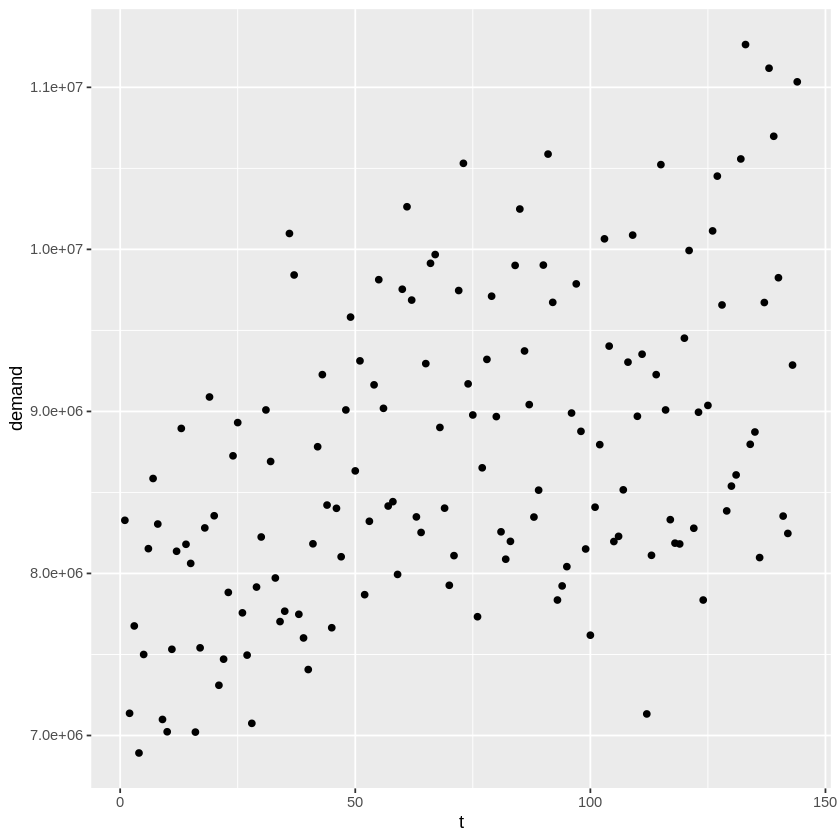

In [4]:
data$t = seq.int(nrow(data))
head(data)
scatter_plot('demand', 't')

In [5]:
predictors <- c('t')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2029494  -637871  -126667   640550  1871060 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7933446     140920  56.297  < 2e-16 ***
t              10974       1686   6.508 1.22e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 841100 on 142 degrees of freedom
Multiple R-squared:  0.2297,	Adjusted R-squared:  0.2243 
F-statistic: 42.35 on 1 and 142 DF,  p-value: 1.22e-09




	RESET test

data:  model
RESET = 2.5261, df1 = 1, df2 = 141, p-value = 0.1142


 lag Autocorrelation D-W Statistic p-value
   1       0.3872942      1.200939       0
 Alternative hypothesis: rho != 0


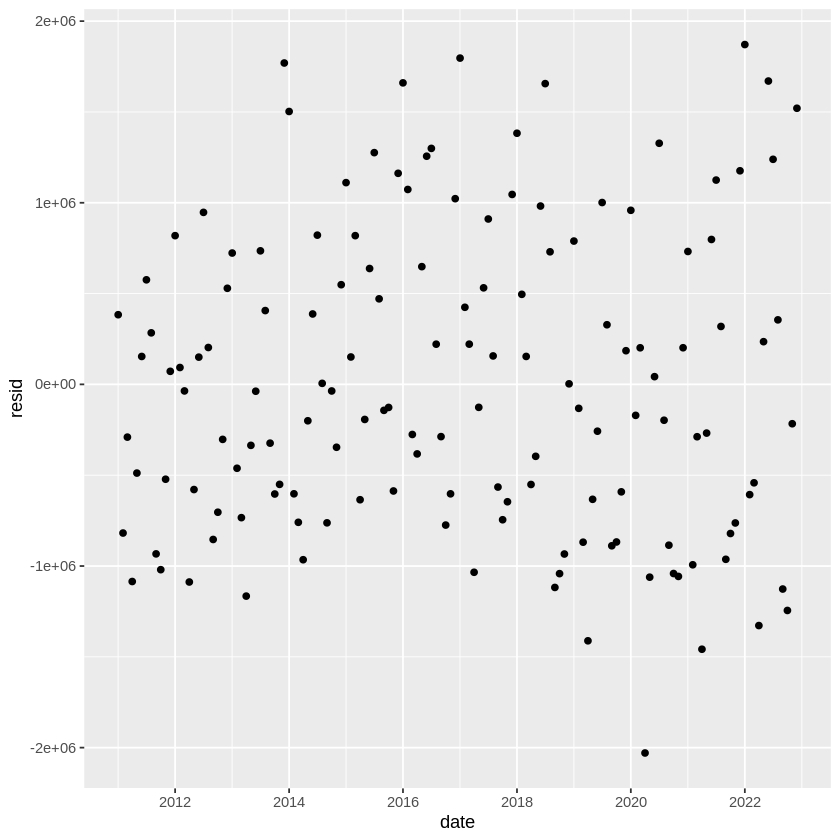

In [6]:
reset_test(model)
autocorr_test(model, data)

[1] "The p-value of the Breusch-Pagan test is 0.0035097898409729"


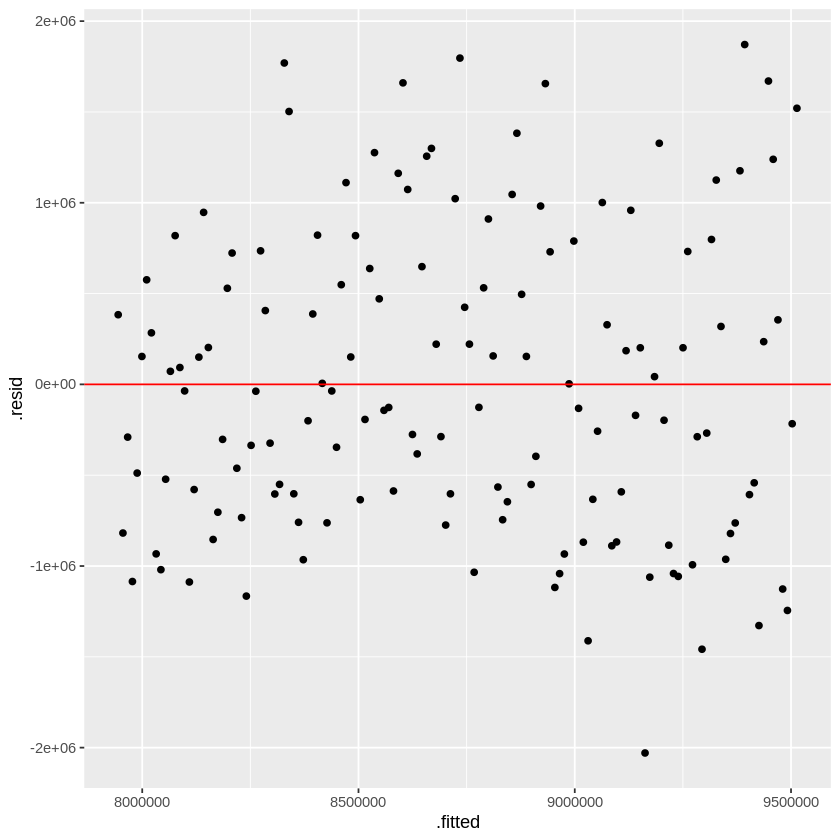

In [7]:
heterosk_check(model)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


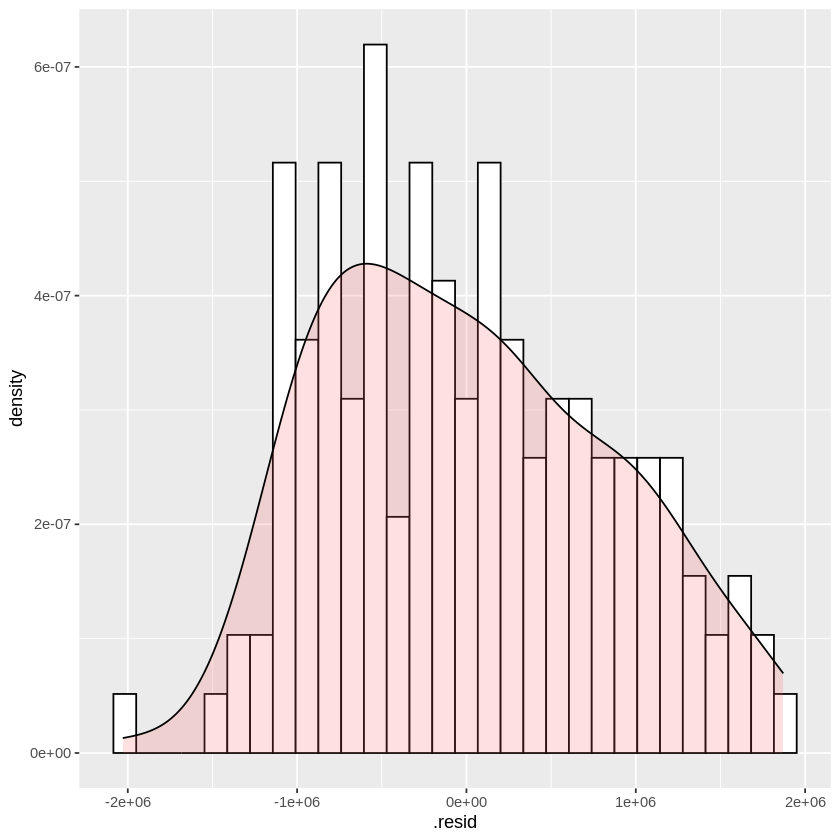

In [8]:
res_dist(model)

Warning message in predict.lm(model, data = predictors_df, interval = "predict"):
“predictions on current data refer to _future_ responses
”


[1] "There are 4 true values outside the prediction interval, with n=144"


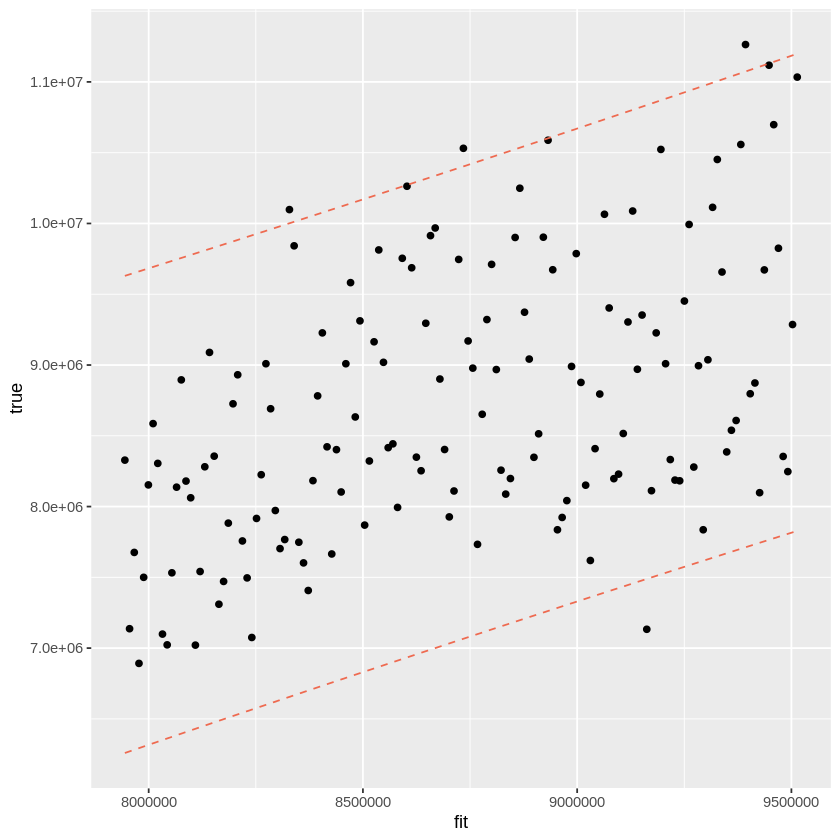

In [9]:
pred_intervals(model, predictors, data)

## Model 2: Adding temperature data

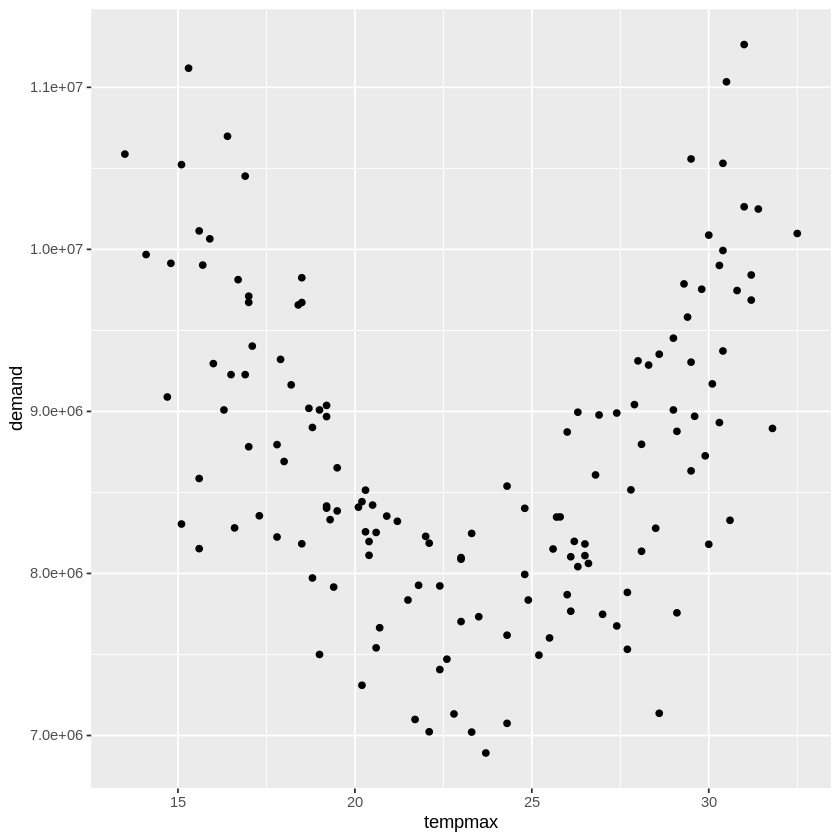

In [10]:
scatter_plot('demand', 'tempmax')

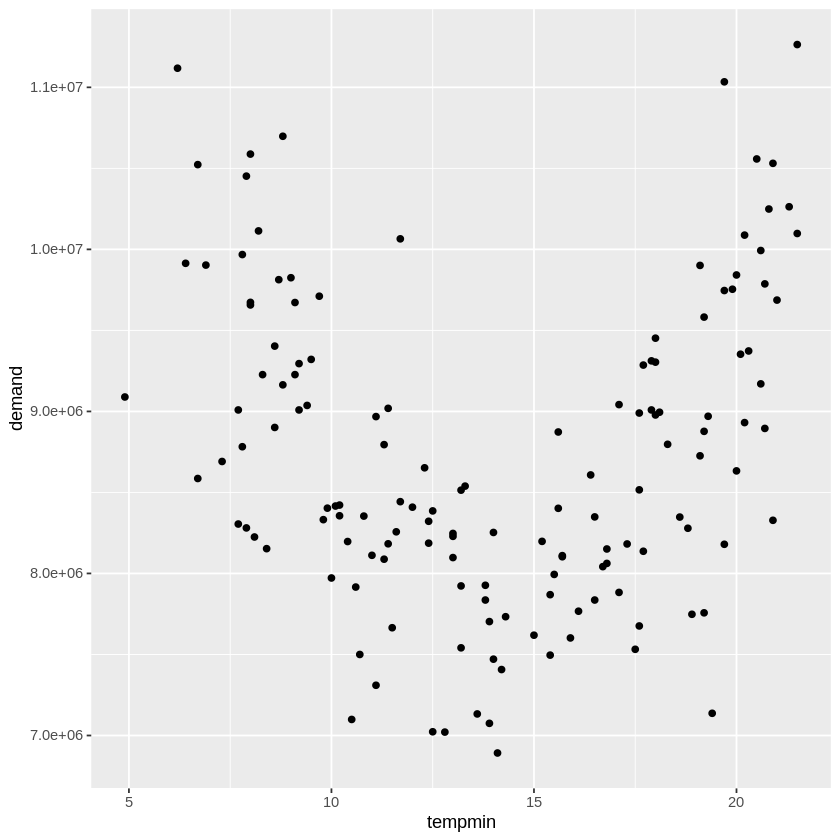

In [11]:
# tempmin plot
scatter_plot('demand', 'tempmin')

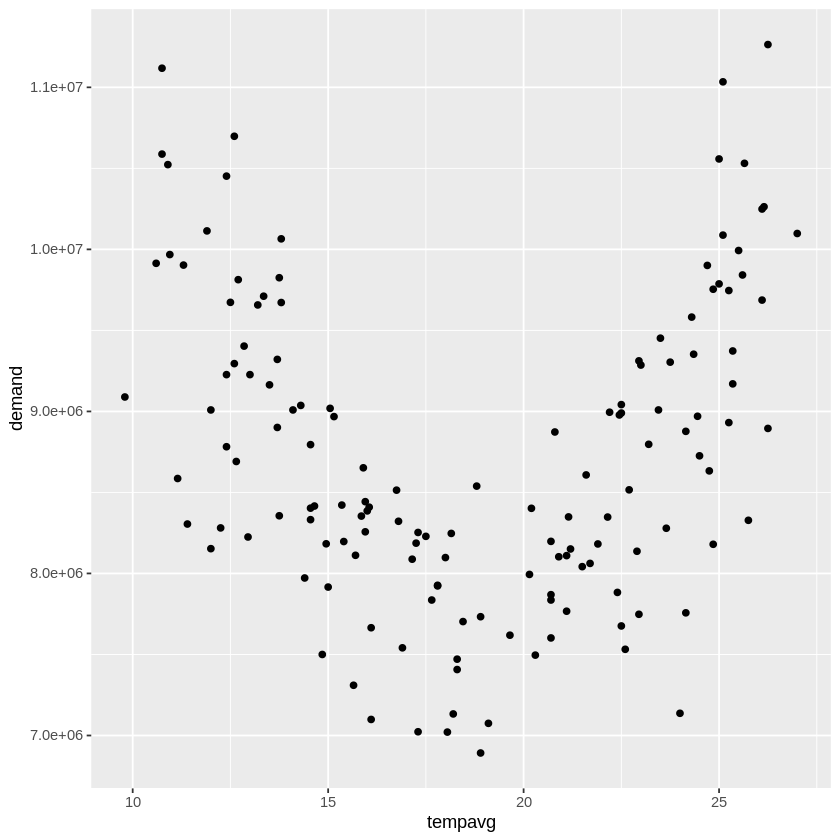

In [12]:
data$tempavg = (data$tempmax + data$tempmin) / 2
scatter_plot('demand', 'tempavg')

In [13]:
data$tempavg2 = data$tempavg^2
predictors <- c('t', 'tempavg2', 'tempavg')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1195668  -275175     4575   275692   991090 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 19915581.7   640588.9   31.09   <2e-16 ***
t              11601.4      883.4   13.13   <2e-16 ***
tempavg2       37271.9     1917.6   19.44   <2e-16 ***
tempavg     -1386385.7    71930.7  -19.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 440400 on 140 degrees of freedom
Multiple R-squared:  0.7918,	Adjusted R-squared:  0.7874 
F-statistic: 177.5 on 3 and 140 DF,  p-value: < 2.2e-16




	RESET test

data:  model
RESET = 2.7677, df1 = 1, df2 = 139, p-value = 0.09843


 lag Autocorrelation D-W Statistic p-value
   1       0.2068743      1.550872   0.002
 Alternative hypothesis: rho != 0


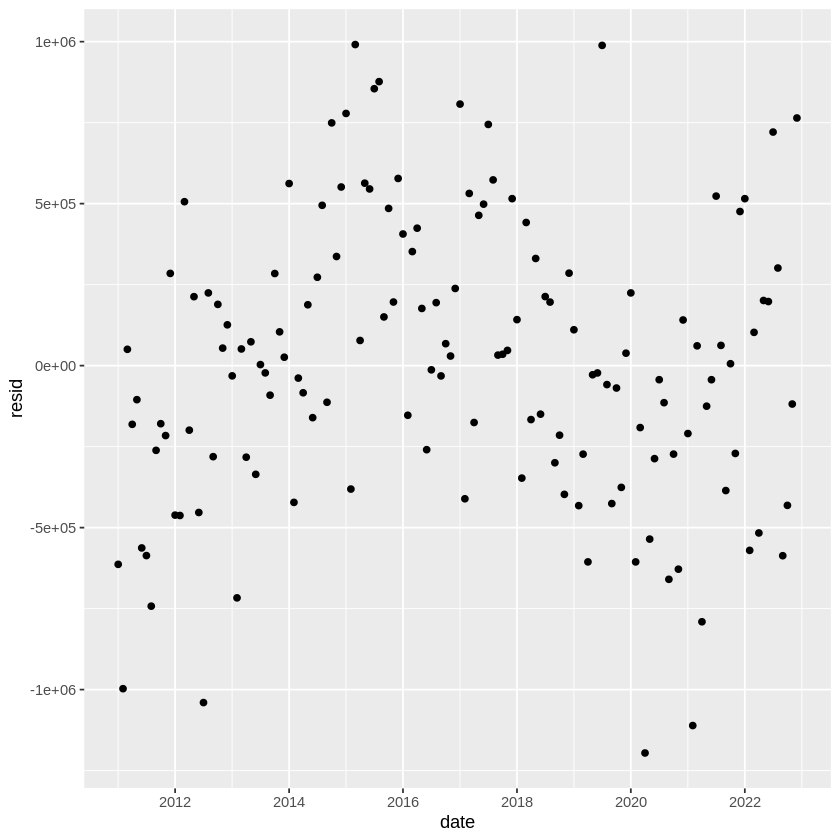

In [14]:
reset_test(model)
autocorr_test(model, data)

In [15]:
hyp_test(model, predictors)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,143,1.304259e+14,NA,NA,NA,NA
2,140,2.714941e+13,3,1.032765e+14,177.5202,1.641339e-47


[1] "The p-value of the Breusch-Pagan test is 0.526693836715556"


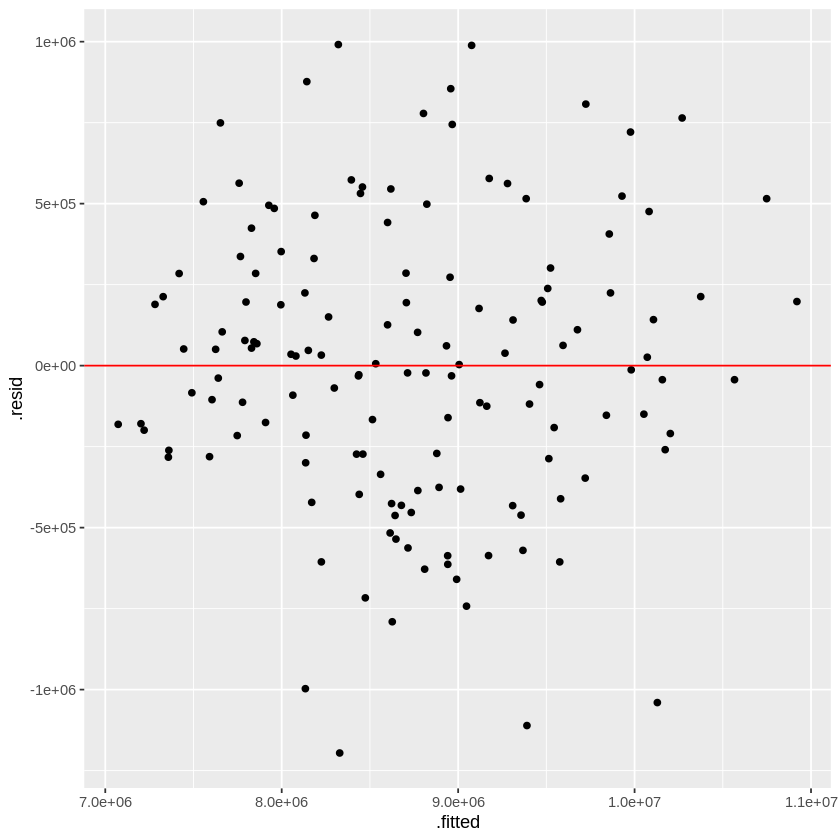

In [16]:
# Plotting for heteroskedasticity
heterosk_check(model)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


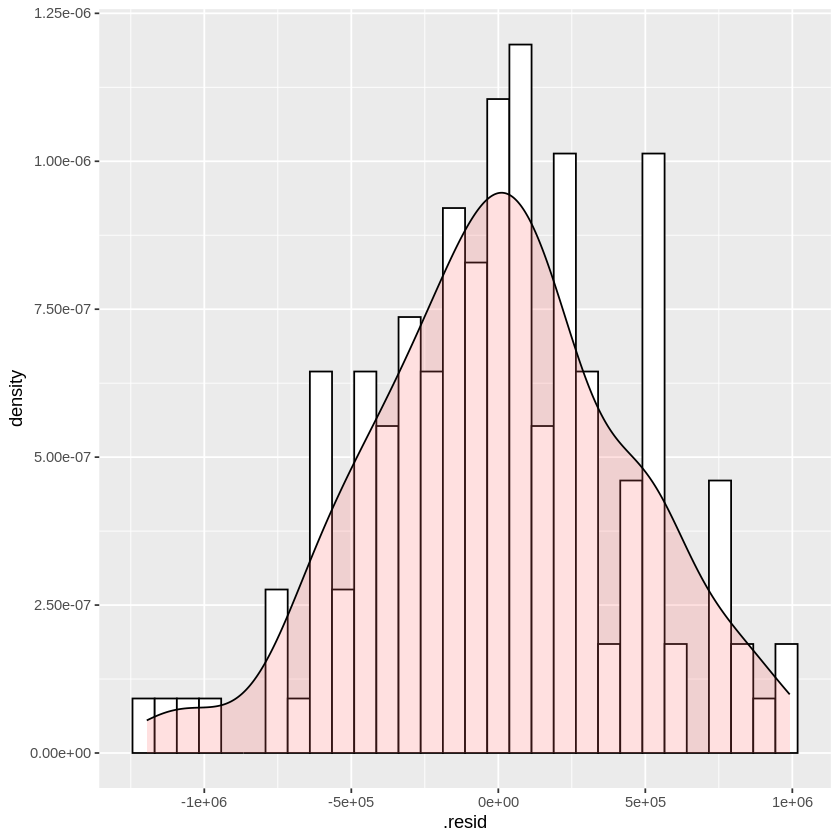

In [17]:
# Plotting the distribution of the residuals
res_dist(model)

Warning message in predict.lm(model, data = predictors_df, interval = "predict"):
“predictions on current data refer to _future_ responses
”


[1] "There are 6 true values outside the prediction interval, with n=144"


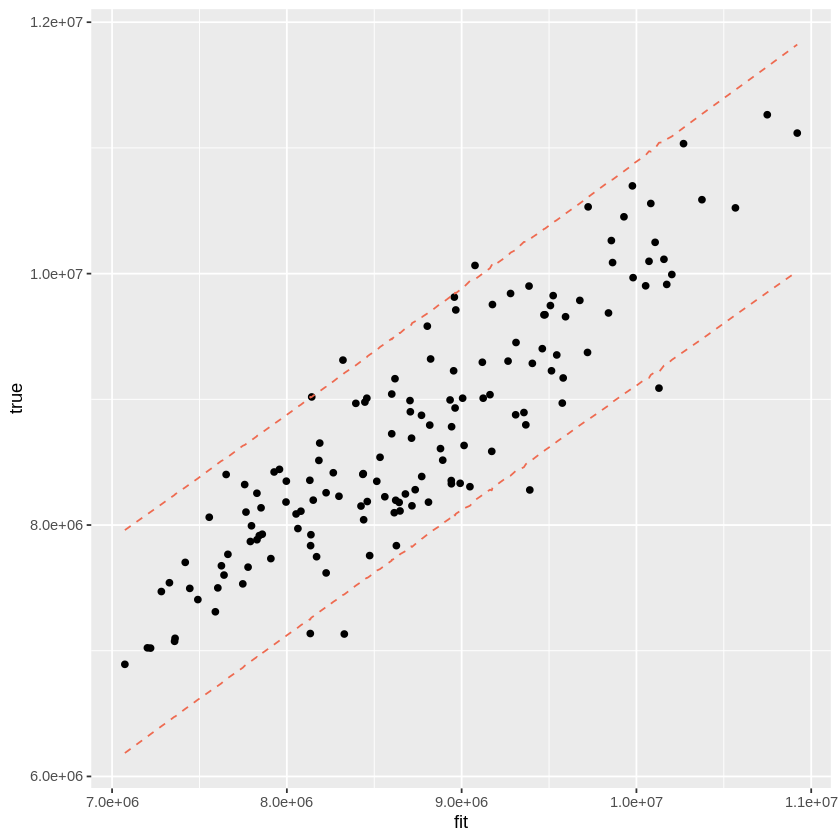

In [18]:
pred_intervals(model, predictors, data)

## Model 3: Adding Inflation Adjusted Electricity Price

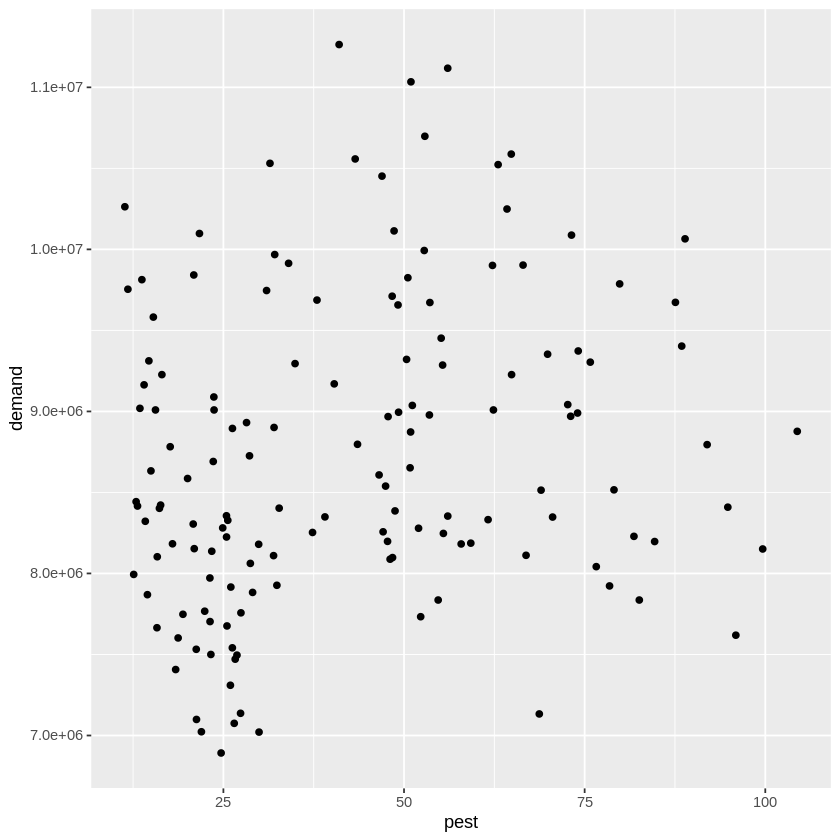

In [19]:
scatter_plot('demand', 'pest')

In [20]:
predictors <- c('t', 'tempavg2', 'tempavg', 'pest')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1182655  -233357   -10726   273962  1231080 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 19904182     618770  32.167  < 2e-16 ***
t              14294       1176  12.150  < 2e-16 ***
tempavg2       36952       1855  19.923  < 2e-16 ***
tempavg     -1373830      69582 -19.744  < 2e-16 ***
pest           -6983       2100  -3.324  0.00113 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 425400 on 139 degrees of freedom
Multiple R-squared:  0.8072,	Adjusted R-squared:  0.8016 
F-statistic: 145.5 on 4 and 139 DF,  p-value: < 2.2e-16




	RESET test

data:  model
RESET = 1.5197, df1 = 1, df2 = 138, p-value = 0.2198


 lag Autocorrelation D-W Statistic p-value
   1         0.16186      1.649013   0.022
 Alternative hypothesis: rho != 0


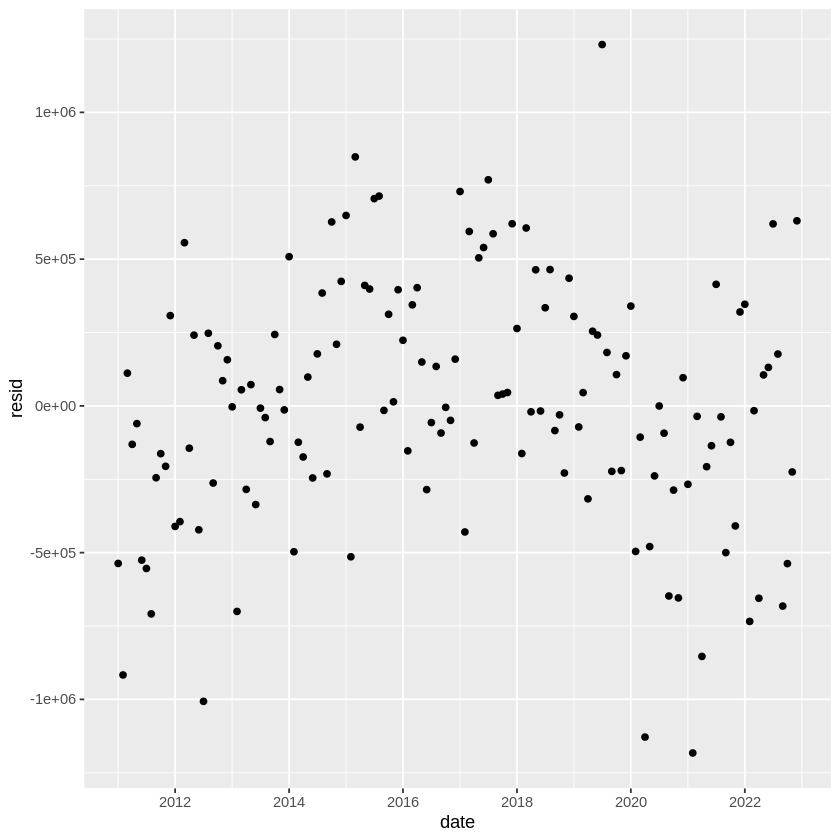

In [21]:
reset_test(model)
autocorr_test(model, data)

In [22]:
hyp_test(model, predictors)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,143,1.304259e+14,NA,NA,NA,NA
2,139,2.514978e+13,4,1.052761e+14,145.4623,1.191133e-48


[1] "The p-value of the Breusch-Pagan test is 0.725374062156207"


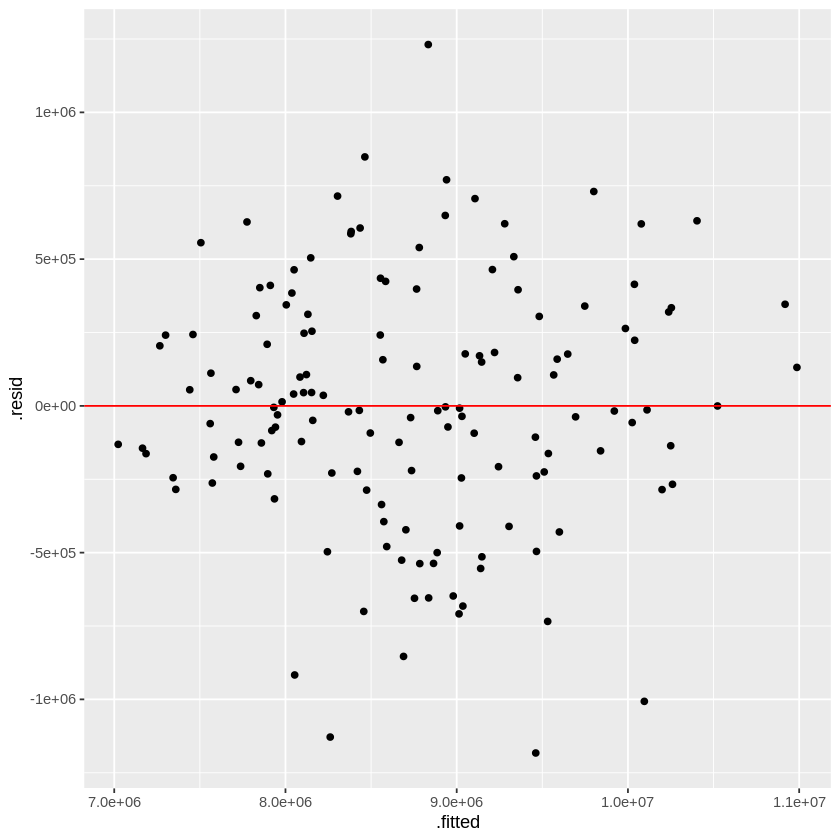

In [23]:
heterosk_check(model)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


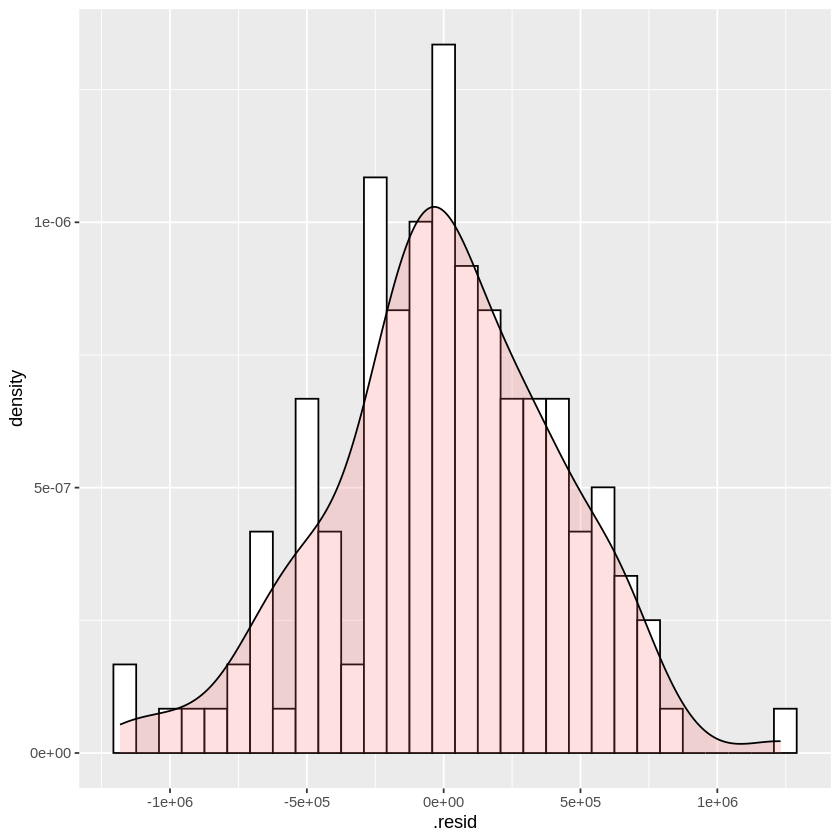

In [24]:
res_dist(model)

Warning message in predict.lm(model, data = predictors_df, interval = "predict"):
“predictions on current data refer to _future_ responses
”


[1] "There are 6 true values outside the prediction interval, with n=144"


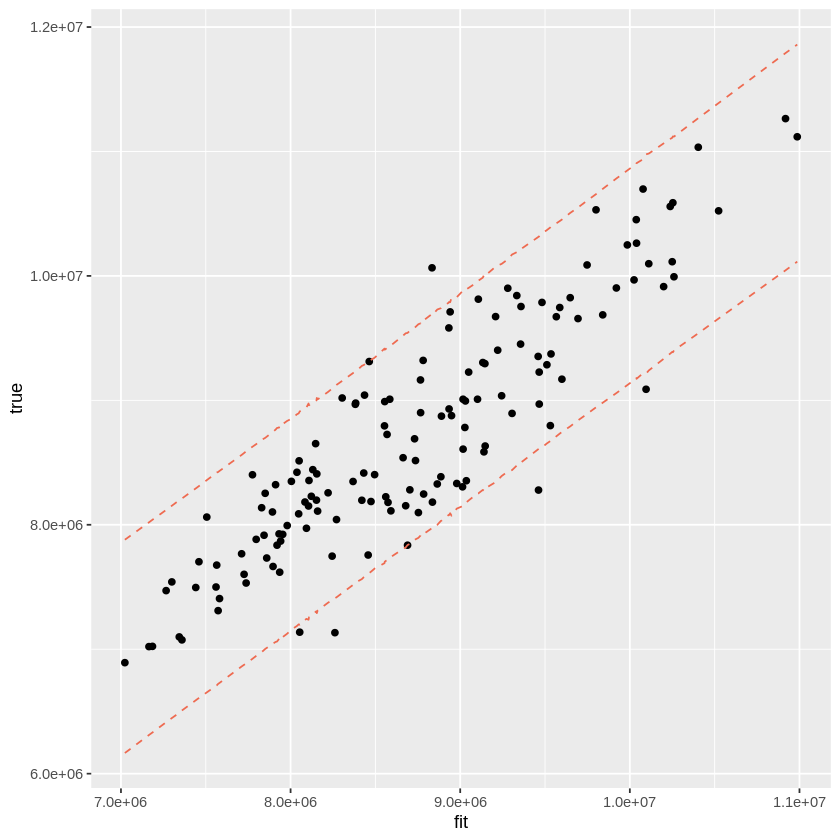

In [25]:
pred_intervals(model, predictors, data)

### Model 4: Taking into Account Wages

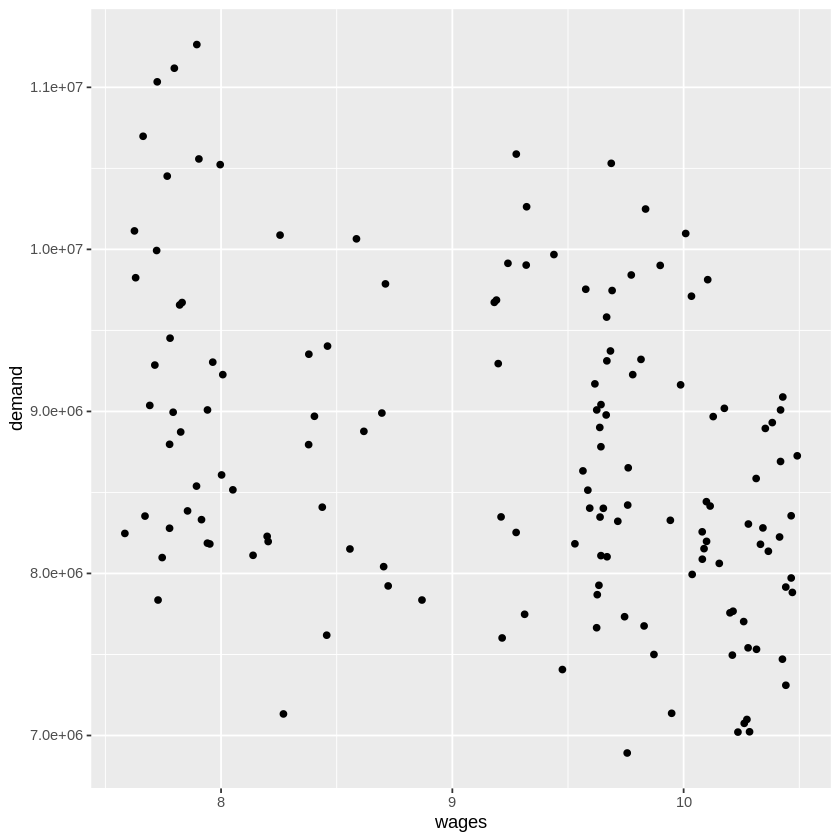

In [26]:
scatter_plot('demand', 'wages')

In [27]:
predictors <- c('t', 'tempavg2', 'tempavg', 'pest', 'wages')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1067691  -234403   -25095   261736  1254223 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15527166    1039988  14.930  < 2e-16 ***
t              22834       2014  11.339  < 2e-16 ***
tempavg2       36984       1711  21.616  < 2e-16 ***
tempavg     -1372901      64187 -21.389  < 2e-16 ***
pest           -7215       1938  -3.723 0.000286 ***
wages         404848      80410   5.035 1.47e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 392400 on 138 degrees of freedom
Multiple R-squared:  0.8371,	Adjusted R-squared:  0.8312 
F-statistic: 141.8 on 5 and 138 DF,  p-value: < 2.2e-16




	RESET test

data:  model
RESET = 5.3096, df1 = 1, df2 = 137, p-value = 0.02271


 lag Autocorrelation D-W Statistic p-value
   1      0.03466243       1.91011    0.33
 Alternative hypothesis: rho != 0


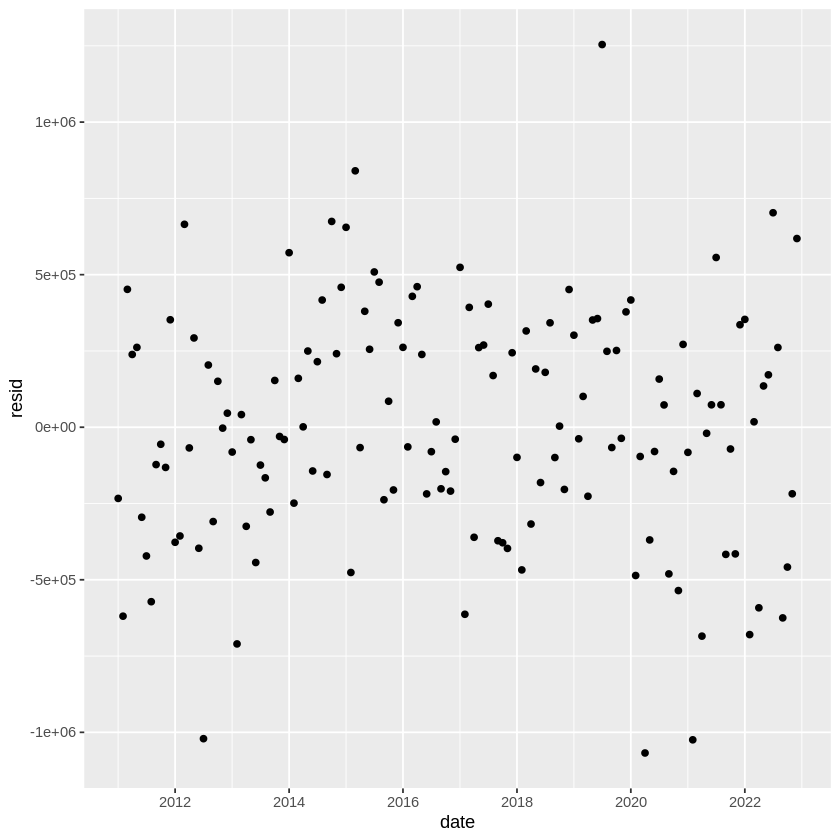

In [28]:
reset_test(model)
autocorr_test(model, data)

In [29]:
hyp_test(model, predictors)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,143,1.304259e+14,NA,NA,NA,NA
2,138,2.124692e+13,5,1.09179e+14,141.8248,1.430919e-52


[1] "The p-value of the Breusch-Pagan test is 0.71606338033049"


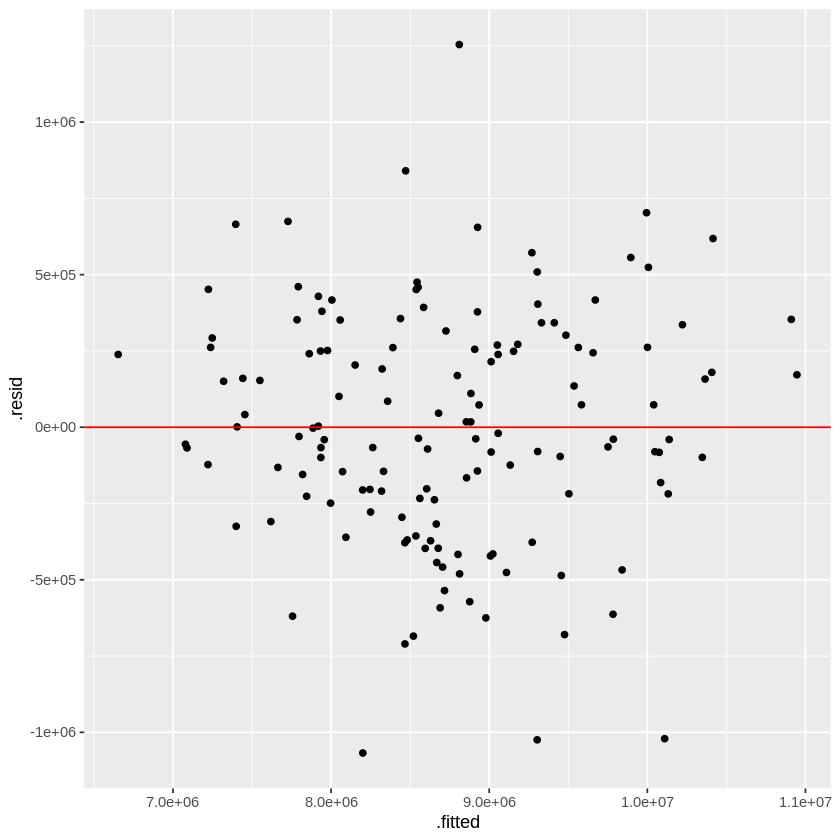

In [30]:
heterosk_check(model)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


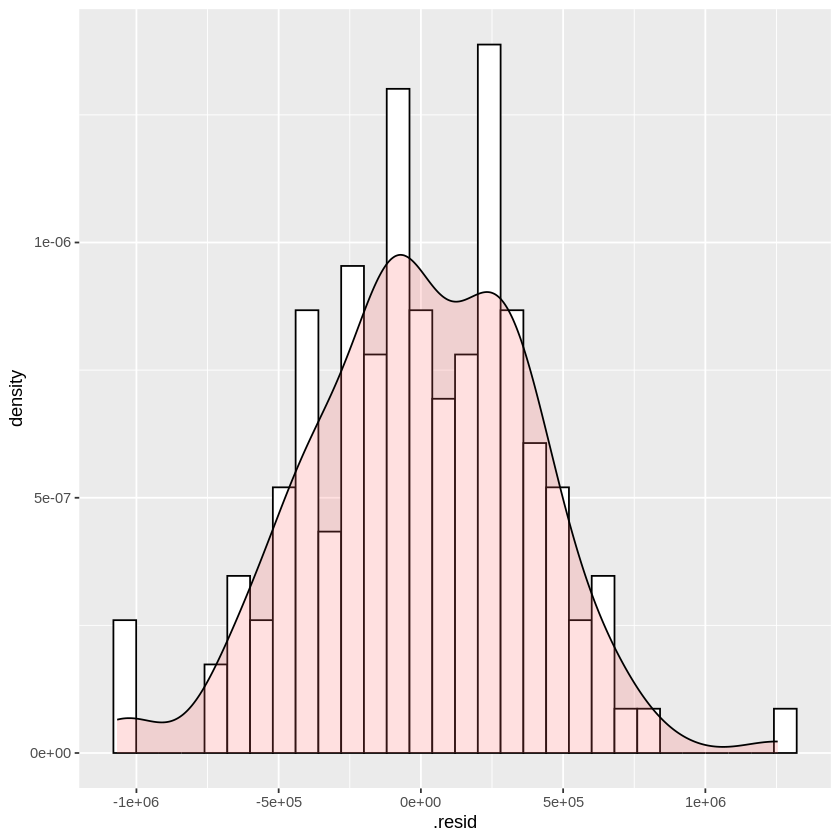

In [31]:
res_dist(model)

Warning message in predict.lm(model, data = predictors_df, interval = "predict"):
“predictions on current data refer to _future_ responses
”


[1] "There are 5 true values outside the prediction interval, with n=144"


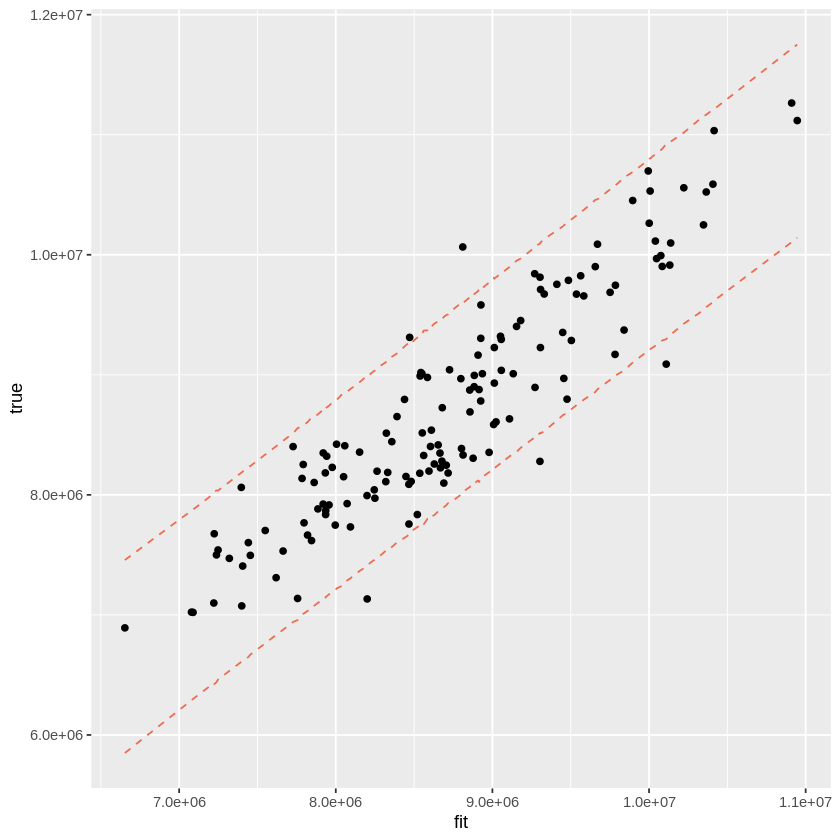

In [32]:
pred_intervals(model, predictors, data)

### Model 5: Taking into account economic activity


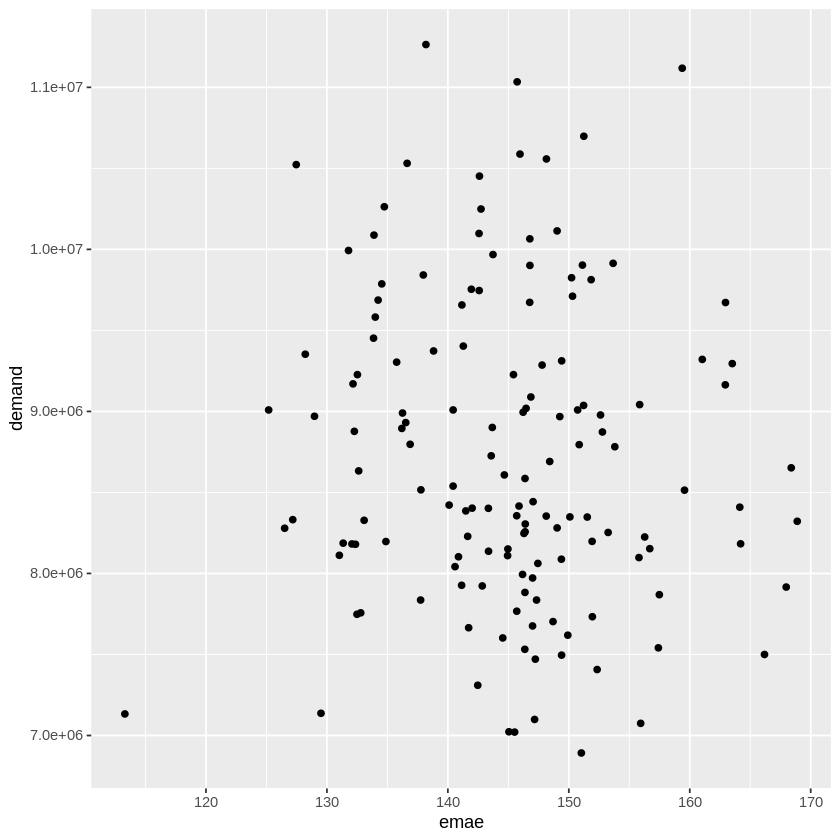

In [33]:
scatter_plot('demand', 'emae')

In [34]:
predictors <- c('t', 'tempavg2', 'tempavg', 'pest', 'wages', 'emae')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-987628 -220103     430  254690 1230343 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 14412487    1020543  14.122  < 2e-16 ***
t              21225       1945  10.911  < 2e-16 ***
tempavg2       38634       1668  23.166  < 2e-16 ***
tempavg     -1421477      61874 -22.974  < 2e-16 ***
pest           -6217       1850  -3.360 0.001008 ** 
wages         314177      79200   3.967 0.000117 ***
emae           16013       3875   4.132 6.22e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 371300 on 137 degrees of freedom
Multiple R-squared:  0.8551,	Adjusted R-squared:  0.8488 
F-statistic: 134.8 on 6 and 137 DF,  p-value: < 2.2e-16




	RESET test

data:  model
RESET = 1.8758, df1 = 1, df2 = 136, p-value = 0.1731


 lag Autocorrelation D-W Statistic p-value
   1      0.08535328      1.815599    0.12
 Alternative hypothesis: rho != 0


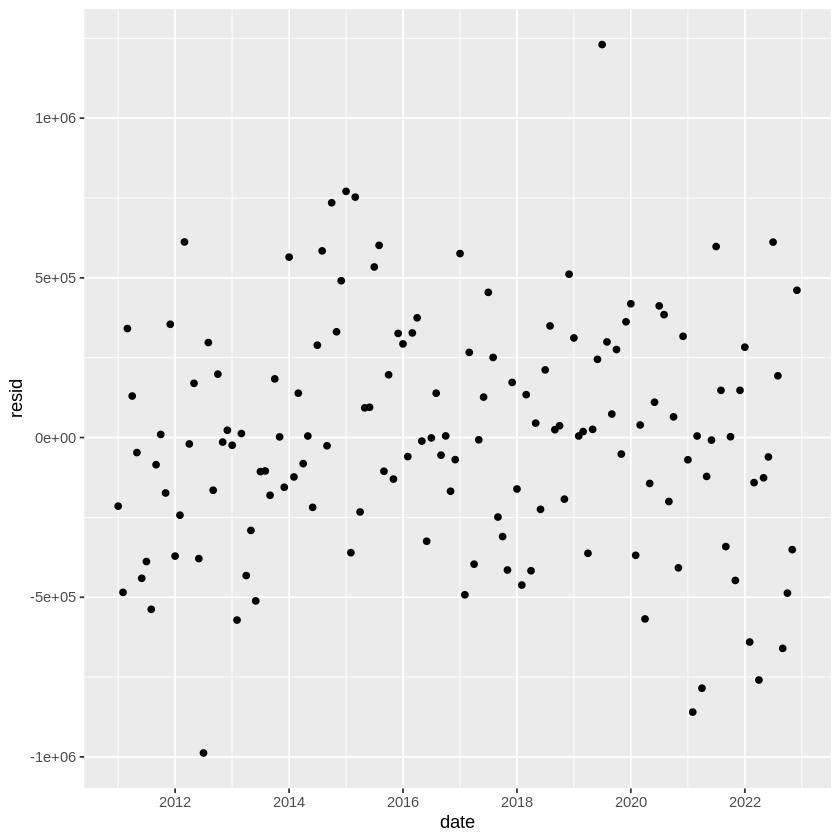

In [35]:
reset_test(model)
autocorr_test(model, data)

In [36]:
hyp_test(model, predictors)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,143,1.304259e+14,NA,NA,NA,NA
2,137,1.889238e+13,6,1.115335e+14,134.7994,6.005633e-55


[1] "The p-value of the Breusch-Pagan test is 0.597859198392176"


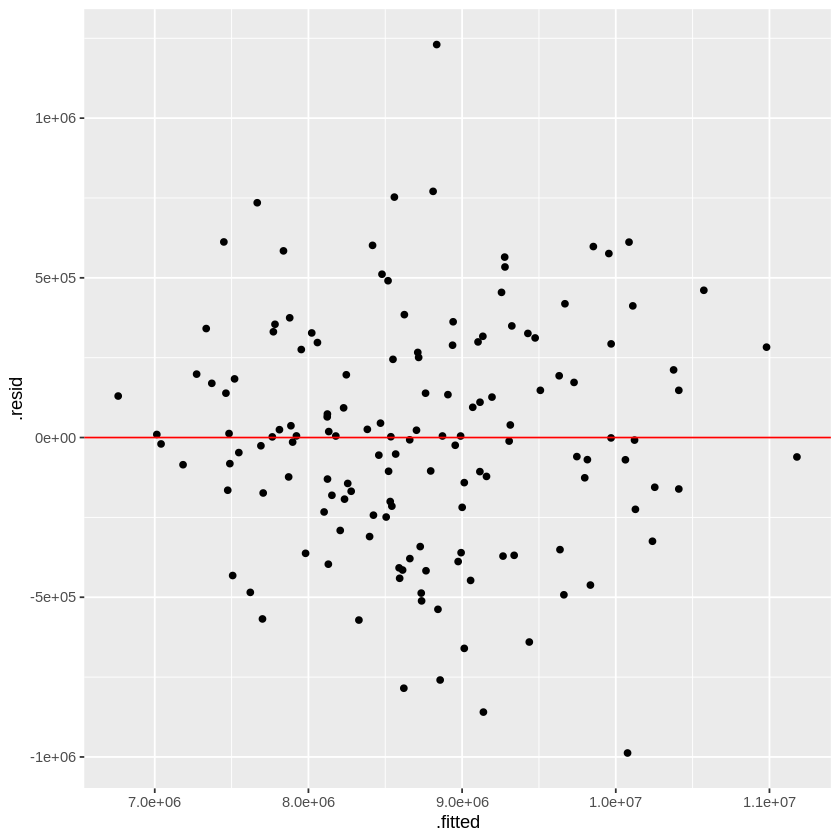

In [37]:
heterosk_check(model)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


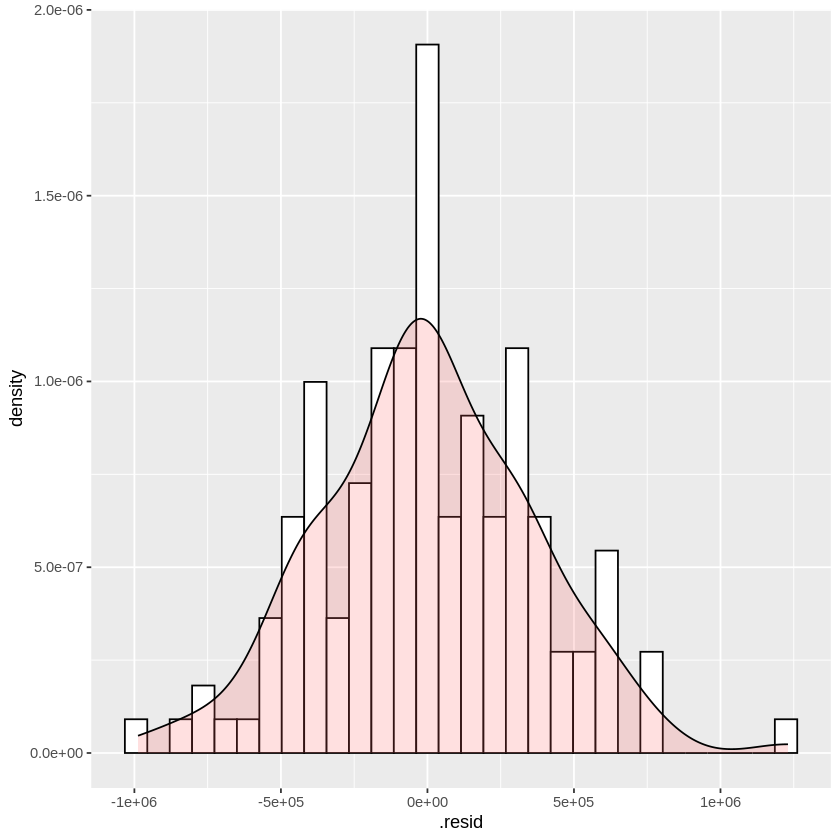

In [38]:
res_dist(model)

Warning message in predict.lm(model, data = predictors_df, interval = "predict"):
“predictions on current data refer to _future_ responses
”


[1] "There are 7 true values outside the prediction interval, with n=144"


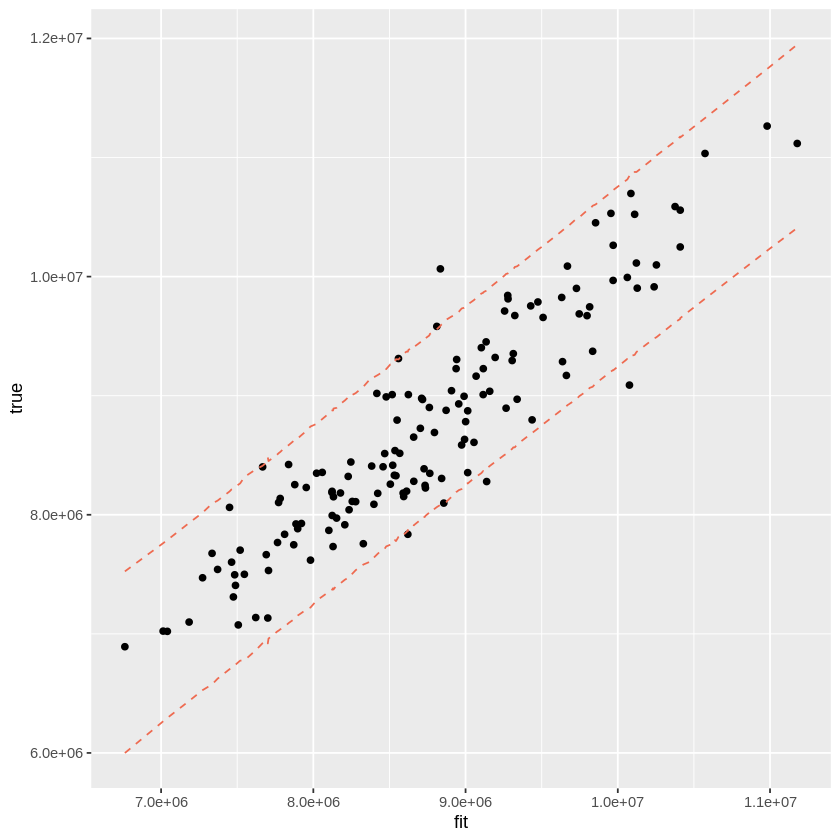

In [39]:
pred_intervals(model, predictors, data)

### Model 6: Trying log(pest)

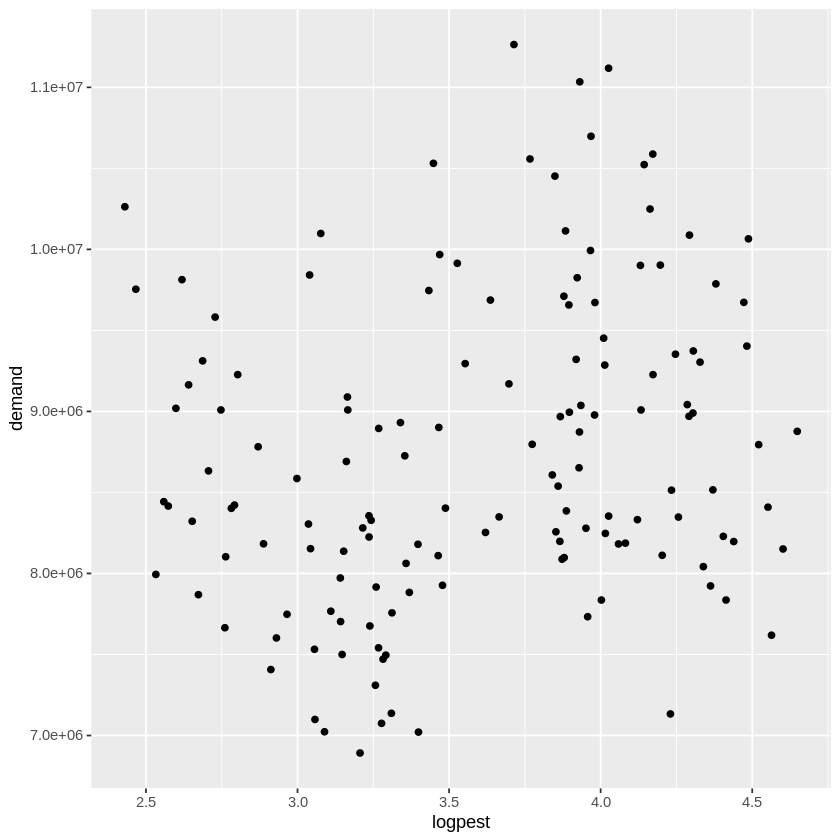

In [40]:
data$logpest = log(data$pest)
scatter_plot('demand', 'logpest')

In [41]:
predictors <- c('t', 'tempavg2', 'tempavg', 'logpest', 'wages', 'emae')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-972764 -215257    2676  227241 1211955 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15274960    1012162  15.091  < 2e-16 ***
t              22256       1914  11.628  < 2e-16 ***
tempavg2       38758       1617  23.968  < 2e-16 ***
tempavg     -1426205      60004 -23.769  < 2e-16 ***
logpest      -332004      74212  -4.474 1.60e-05 ***
wages         320936      76999   4.168 5.41e-05 ***
emae           15812       3758   4.208 4.64e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 360900 on 137 degrees of freedom
Multiple R-squared:  0.8632,	Adjusted R-squared:  0.8572 
F-statistic: 144.1 on 6 and 137 DF,  p-value: < 2.2e-16




	RESET test

data:  model
RESET = 2.9159, df1 = 1, df2 = 136, p-value = 0.08999


 lag Autocorrelation D-W Statistic p-value
   1      0.03181734      1.923242   0.418
 Alternative hypothesis: rho != 0


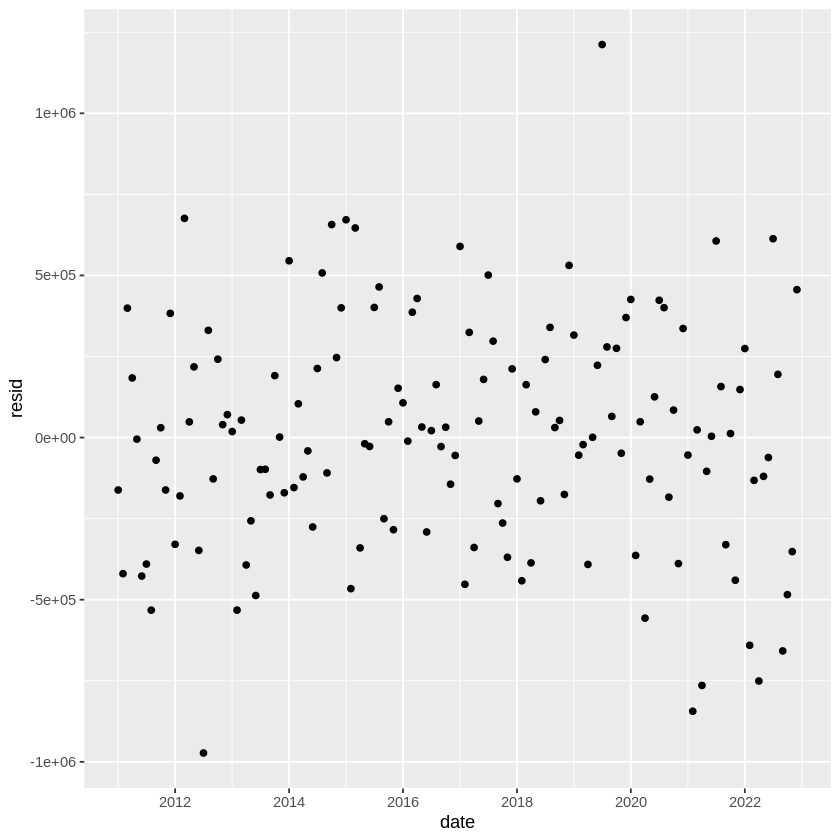

In [42]:
reset_test(model)
autocorr_test(model, data)

In [43]:
hyp_test(model, predictors)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,143,1.304259e+14,NA,NA,NA,NA
2,137,1.784300e+13,6,1.125829e+14,144.0702,1.220272e-56


[1] "The p-value of the Breusch-Pagan test is 0.62064596800329"


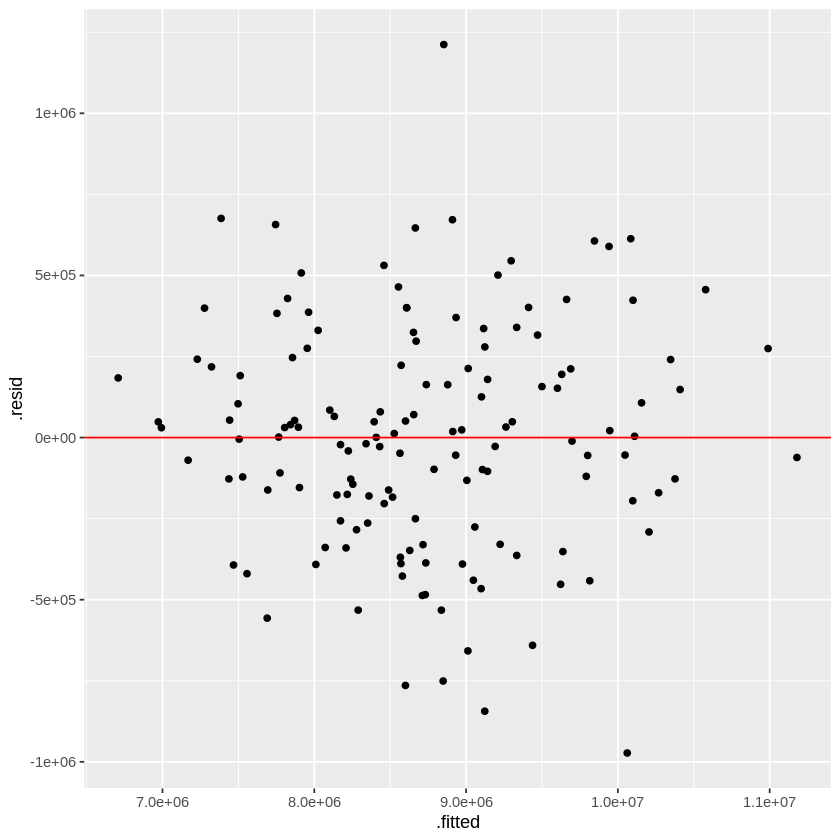

In [44]:
heterosk_check(model)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


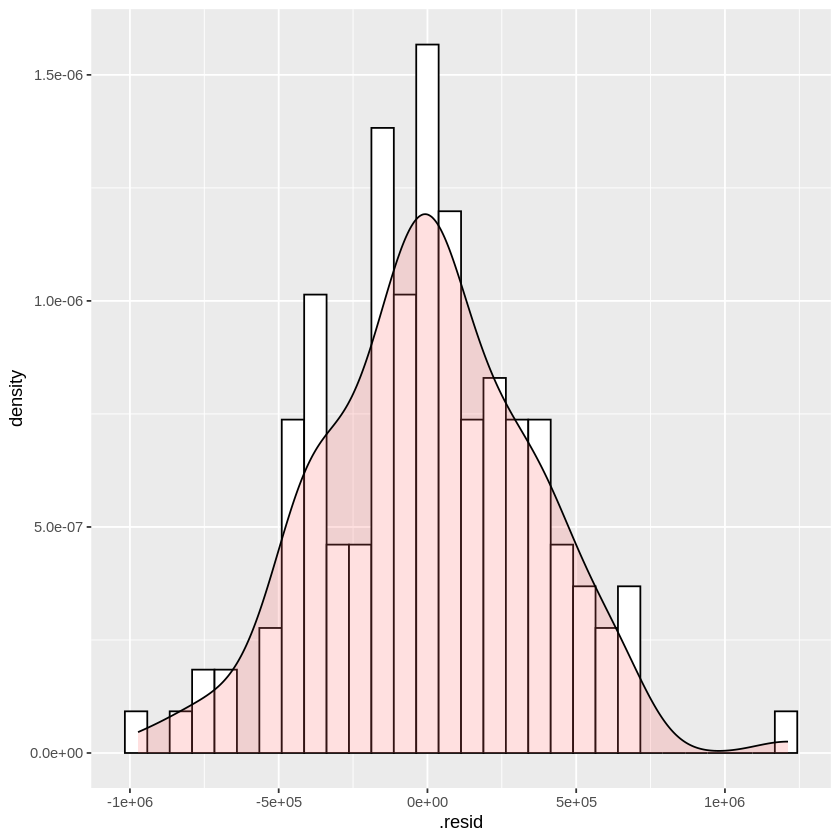

In [45]:
res_dist(model)

Warning message in predict.lm(model, data = predictors_df, interval = "predict"):
“predictions on current data refer to _future_ responses
”


[1] "There are 5 true values outside the prediction interval, with n=144"


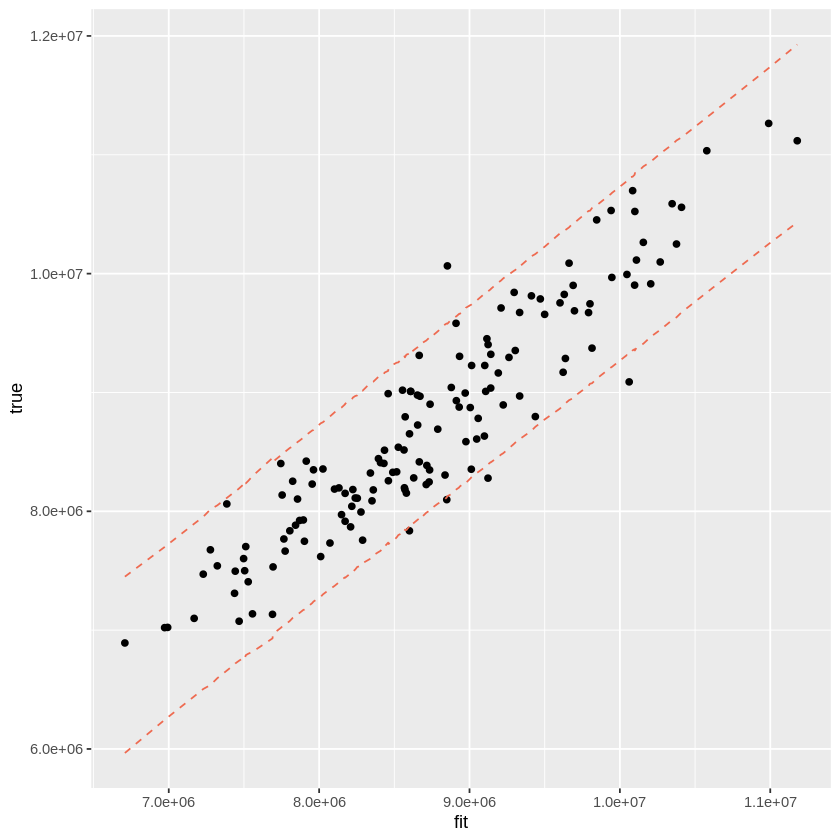

In [46]:
pred_intervals(model, predictors, data)